Few people train an entire CNN from scratch because it is rare to have dataset with sufficient size. It is common to pretrain a ConvNet on a very large dataset and use the ConvNet as initialization or a fixed feature extractor for the task of interest

Transfer learning can help in:
1. Finetuning the convnet.
2. Freeze weights for all network except that of the final fully connected layer.

In [23]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from copy import deepcopy
plt.ion()

In [2]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [40]:
data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
# visualize training images to understand the data augmentation
def imshow(inp, title=None):
    """Imshow for Tensor"""
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

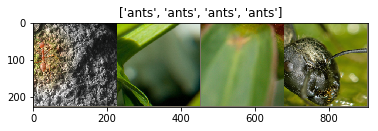

In [42]:
# Get a batch of training data

inputs, classes = next(iter(dataloader['train']))

# make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training model

In [43]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [44]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode = was_training)

Load pretrained model and reset final layer

In [45]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [46]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      num_epochs=30)

Epoch 0/29
----------
train Loss: 0.5910 Acc: 0.7172
val Loss: 0.1919 Acc: 0.9216

Epoch 1/29
----------
train Loss: 0.5049 Acc: 0.7623
val Loss: 0.3176 Acc: 0.8431

Epoch 2/29
----------
train Loss: 0.5274 Acc: 0.8074
val Loss: 0.5003 Acc: 0.8366

Epoch 3/29
----------
train Loss: 0.5423 Acc: 0.7787
val Loss: 0.2706 Acc: 0.9150

Epoch 4/29
----------
train Loss: 0.5743 Acc: 0.7623
val Loss: 0.2775 Acc: 0.9085

Epoch 5/29
----------
train Loss: 0.4886 Acc: 0.7828
val Loss: 0.2688 Acc: 0.9020

Epoch 6/29
----------
train Loss: 0.6567 Acc: 0.7500
val Loss: 0.3641 Acc: 0.8627

Epoch 7/29
----------
train Loss: 0.3447 Acc: 0.8443
val Loss: 0.2443 Acc: 0.9346

Epoch 8/29
----------
train Loss: 0.3276 Acc: 0.8730
val Loss: 0.2831 Acc: 0.9346

Epoch 9/29
----------
train Loss: 0.2444 Acc: 0.8811
val Loss: 0.2785 Acc: 0.9216

Epoch 10/29
----------
train Loss: 0.2501 Acc: 0.8975
val Loss: 0.2367 Acc: 0.9346

Epoch 11/29
----------
train Loss: 0.3125 Acc: 0.8648
val Loss: 0.2476 Acc: 0.9346

Ep

For convnet to serve as a fixed feature extractor, we need to freeze all network except the final layer

To do this, requires_grad == false is needed to freeze the parameters so that the gradients are not commputed in backward()


In [47]:
model_conv = models.resnet18(pretrained=True)

In [49]:
for param in model_conv.parameters():
    param.required_grad = False

In [50]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)



In [51]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                        num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6363 Acc: 0.6844
val Loss: 0.7197 Acc: 0.6340

Epoch 1/24
----------
train Loss: 0.6183 Acc: 0.7295
val Loss: 0.2148 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.4560 Acc: 0.7828
val Loss: 0.7190 Acc: 0.7124

Epoch 3/24
----------
train Loss: 0.4937 Acc: 0.7869
val Loss: 0.1942 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4943 Acc: 0.7992
val Loss: 0.4405 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.3783 Acc: 0.8279
val Loss: 0.1739 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.5136 Acc: 0.7992
val Loss: 0.1911 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3597 Acc: 0.8607
val Loss: 0.2051 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3167 Acc: 0.8484
val Loss: 0.1995 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3089 Acc: 0.8607
val Loss: 0.2110 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3496 Acc: 0.8525
val Loss: 0.1947 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.4266 Acc: 0.8197
val Loss: 0.1891 Acc: 0.9412

Ep